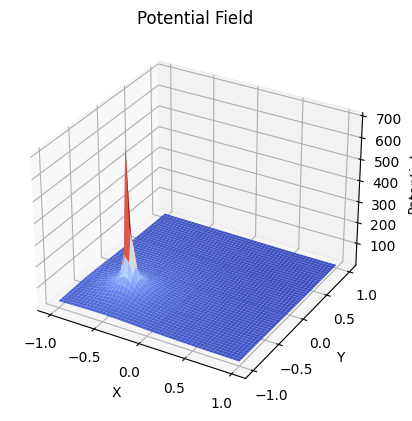

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the size of the grid
N = 50

# Create a meshgrid
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)

# Define the goal position
goal = np.array([0.5, 0.5])

# Define the obstacle position
obstacle = np.array([-0.5, -0.5])

# Define the strength of the goal and obstacle potentials
k_goal = 5
k_obstacle = 10

# Calculate the potential field
U_goal = k_goal * np.sqrt((X - goal[0])**2 + (Y - goal[1])**2)
U_obstacle = k_obstacle / np.sqrt((X - obstacle[0])**2 + (Y - obstacle[1])**2)
U = U_goal + U_obstacle

# Plot the potential field
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
ax.set_title('Potential Field')
plt.show()


In [3]:
import sys
sys.path.append('../')
import lidar_tool

path = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1017_1852/vehicle.tesla.model3.master/velodyne_semantic/0000001577.bin'
lidar_tool.vis_pt(path)

[per label] 13
[label_str] -1.749570369720459 -19.64297103881836 -2.2200863361358643 5.979609489440918 5.155853271484375 2.3341016843914986 0.0 Truck 0.0
[label_str] -50.29932975769043 -24.164518356323242 -2.2661213874816895 1.8974494934082031 5.040367126464844 1.7341997027397156 0.0 Car 257.0
[label_str] 35.212684631347656 -6.986948251724243 -2.357139825820923 6.106971740722656 2.295947551727295 2.0167301297187805 0.0 Car 144.0
[label_str] -46.93398857116699 -7.54019021987915 -2.27884578704834 1.8503837585449219 4.39565372467041 1.475766897201538 0.0 Car 224.0
[label_str] -49.970502853393555 -3.779892385005951 -2.3411388397216797 0.5771369934082031 3.8643161058425903 1.1148613691329956 0.0 Car 238.0
[label_str] 12.242154755613747 40.62789400309191 -1.6831334829330444 1.0351296152733866 3.2393530530672106 0.6564276218414307 0.8726646259971694 Car 229.0
[label_str] 16.391356945037842 -22.29929828643799 -2.278831958770752 2.0488481521606445 4.422094345092773 1.4060283303260803 0.0 Car 24

In [22]:
import open3d as o3d
import numpy as np

# Load point cloud sample data

pre_point = np.fromfile(path, dtype=np.dtype([
                                       ('x', np.float32),
                                       ('y', np.float32),
                                       ('z', np.float32),
                                       ('CosAngle', np.float32),
                                        ('ObjIdx', np.uint32),
                                       ('ObjTag', np.uint32)
                                   ]) ,count=-1)
semantic_point = np.array([list(elem) for elem in pre_point])

pcd  = o3d.geometry.PointCloud()

# keep point -10<x<10, -10<y<10, 0<z<10

semantic_point = semantic_point[(semantic_point[:,0]>-10) & (semantic_point[:,0]<10) & (semantic_point[:,1]>-10) & (semantic_point[:,1]<10) & (semantic_point[:,2]>0) & (semantic_point[:,2]<10)]


pcd.points = o3d.utility.Vector3dVector(semantic_point[:,:3])

# Compute normal vectors for each point
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Estimate normal vectors for each face
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 3

# Extract the point coordinates and normals
points = np.asarray(pcd.points)
normals = np.asarray(pcd.normals)

# Concatenate the point coordinates and normals
data = np.concatenate((points, normals), axis=1)

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)

# Get the cluster labels
labels = kmeans.labels_

# Print the number of points in each cluster
for i in range(n_clusters):
    print('Cluster {}: {} points'.format(i, np.sum(labels == i)))
    # Alpha形状算法提取点云表面
    # Compute the Alpha shape
alpha = 0.2
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd, alpha)

print('Number of triangles: {}'.format(len(mesh.triangles)))

o3d.visualization.draw_geometries([mesh])




/home/ghosnp/miniconda3/envs/carla38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: 689 points
Cluster 1: 265 points
Cluster 2: 663 points
Number of triangles: 856


In [32]:
import numpy as np
from pathlib import Path

def load_pre_label(gt_json_path):
    if Path(gt_json_path).exists():
        pred_box = []
        with open(gt_json_path, 'r') as fobj:

            for line in fobj:
                l = line.strip().split(" ")
                try:
                    cx, cy, cz, sx, sy, sz, yaw, tag, mesh_cnt, time = l[0], l[1],l[2], l[3],l[4], l[5],l[6], l[7], l[8], l[9], l[10]
                    box_data = list(map(float,[ cx, cy, cz, sx, sy, sz, yaw, mesh_cnt]))
                    pred_box.append(box_data)
                    print("[label_str]",line)
                except:
                    print("[entropy infos]",line)
                
        return pred_box

In [13]:
txt_path = '/home/ghosnp/project/fix_space/origin/carla_dataset_tools/raw_data/record_2023_1017_2155/vehicle.tesla.model3.master/velodyne_semantic/0000003232.txt'
import pandas as pd
df = pd.read_csv(txt_path, sep=" ", header=None)
df.columns = ["cx", "cy", "cz", "sx", "sy", "sz", "yaw", "tag", "mesh_cnt", "time"]
df.head()



,cx,cy,cz,sx,sy,sz,yaw,tag,mesh_cnt,time
0,14.776977,28.484735,-1.756945,4.717525,1.894827,1.300940,92.405846,Car,312.0,0.002508
1,-31.549992,-6.980889,-1.666418,3.805800,1.970276,1.475030,180.237434,Car,258.0,0.001933
2,-37.424816,-10.397485,-1.569339,4.611006,2.241713,1.667276,180.187007,Car,66.0,0.000586
3,18.608638,-28.893986,-1.191104,6.365643,2.351174,2.431376,90.306740,Truck,538.0,0.005516
4,-76.218891,-3.473183,-1.465484,4.604510,1.931593,1.854846,-0.003799,Car,0.0,0.000038


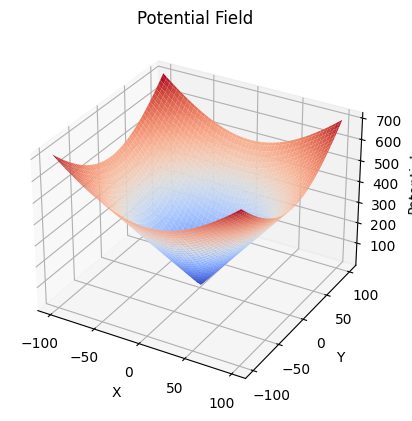

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the size of the grid
N = 100

# Create a meshgrid
x = np.linspace(-100, 100, N)
y = np.linspace(-100, 100, N)
X, Y = np.meshgrid(x, y)

# Define the goal position
goal = np.array([0.5, 0.5])

# Read obstacle positions from DataFrame
obstacles = df[['cx', 'cy']].values

# Define the strength of the goal and obstacle potentials
k_goal = 5
k_obstacle = 10

# Calculate the potential field
U_goal = k_goal * np.sqrt((X - goal[0])**2 + (Y - goal[1])**2)
U_obstacle = np.zeros_like(U_goal)

for obstacle in obstacles:
    U_obstacle += k_obstacle / np.sqrt((X - obstacle[0])**2 + (Y - obstacle[1])**2)

U = U_goal + U_obstacle

# Plot the potential field
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Potential')
ax.set_title('Potential Field')

plt.show()